<a href="https://colab.research.google.com/github/jkoniecznyy/Machine-learning/blob/main/Nerual_Networks_Comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import os
import glob
import time
import datetime

import numpy as np
import tensorflow

import matplotlib.pyplot as plt
from google.colab import drive

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input as efficientnet_preprocess_input

In [ ]:
!python --version
print(np.__version__)
print(tensorflow.__version__)
print(tensorflow.keras.__version__)

Python 3.10.12
1.22.4
2.12.0
2.12.0


In [ ]:
!nvidia-smi

Fri Aug  4 16:49:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |   4931MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
drive.mount('/content/drive')
configuration_time_start = time.time()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Hyperparameters

In [ ]:
LR = 0.001 #0.002
BATCH_SIZE = 32 #64
EPOCHS = 10
DAY=datetime.datetime.now().strftime("%m_%d")

## Functions


In [ ]:
def count_files(directory_path):
    count = 0
    for _, _, files in os.walk(directory_path):
        count += len(files)
    return count

def count_files_in_classes(directory_path, classes):
    print("count_files_in_classes: ", directory_path, "classes", classes)
    for dir in ['train', 'test', 'valid']:
      directory_path = f"{directory_path}{dir}/"
      print(f'{dir}: {count_files(directory_path)}')
      for clas in classes:
        directory_path = f"{directory_path}{dir}/{clas}/"
        print(f'    {clas}: {count_files(directory_path)}')


def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        print ('No directory')
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
              cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Arguments:
        base_model: keras model (without a top layer)
        nb_classes: number of classes
    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)  # Regularize with dropout
    # Add the last layer and ((optionally) a dense layer
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model



def setup_to_transfer_learn(model, args):
    """Freezes all layers but the last one and compiles the model"""

    # TODO: Set all the layers but last one to not trainable.
    # Note: If you added more than one layer in the add_new_last_layer
    # function you should set all these layers to trainable.
    for layer in model.layers[:-1]:
      layer.trainable=False
    model.layers[-1].trainable=True
    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def setup_to_finetune(model, args, not_trainable):
    """Freezes the first not_trainable layers, and unfreezes the rest
    Arguments:
        model: keras model
        not_trainable: number of not trainable layers
    """

    #Set the layers [0:not_trainable] to not trainable. Set the layers [not_trainable:] to trainable
    for i in range(not_trainable):
      model.layers[i].trainable=False

    for i in range(not_trainable, len(model.layers)):
      model.layers[i].trainable=True
    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def trainable_params(model, output_format = 'en_US'):
    """Computes the number of trainable parameters in the model.
    Args:
        model: keras model
        output_format: (default: 'en_US')
            'int'   - number of trainable parameters (12345)
            'en_US' - number of trainable parameters formated to comma separated str ('12,235')
    """

    def nr_to_string(number, separator = ','):
        """
        Changes numbers to string.
        """
        s = '%d' % number
        groups = []
        while s and s[-1].isdigit():
            groups.append(s[-3:])
            s = s[:-3]
        return s + separator.join(reversed(groups))

    # And the real trainable_params function

    ret = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    if output_format == 'en_US':
        return nr_to_string(ret)
    else:
        return ret

In [ ]:
def unpack_history(history, old_history = None):
    if old_history is None:
        new_history = {
            'accuracy' : [],
            'val_accuracy' : [],
            'loss' : [],
            'val_loss' : [],
        }
    else:
        new_history = old_history
    new_history['accuracy'] += history.history['accuracy']
    new_history['val_accuracy'] += history.history['val_accuracy']
    new_history['loss'] += history.history['loss']
    new_history['val_loss'] += history.history['val_loss']
    return new_history

def plot_history(training_history, save_path, title):
    acc = training_history['accuracy']
    val_acc = training_history['val_accuracy']
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = np.arange(len(acc)) + 1

    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(121)
    ax1.plot(epochs, loss, c='g', label='Train')
    ax1.plot(epochs, val_loss, c='r', label='Valid')
    ax1.set_title('Loss')
    ax1.legend(loc='lower left');
    ax1.grid(True)

    ax2 = fig.add_subplot(122)
    ax2.plot(epochs, acc, c='g', label='Train')
    ax2.plot(epochs, val_acc, c='r', label='Valid')
    ax2.set_title(f'Accuracy {title}')
    ax2.grid(True)
    fig.savefig(save_path)
    plt.show()


def process_and_display(history, old_history, save_path, title):
    new_history = unpack_history(history, old_history)
    plot_history(new_history, save_path, title)
    return new_history

In [ ]:
class Args():
    def __init__(self, local_folder):
        self.lr = LR
        self.batch_size = BATCH_SIZE
        self.train_dir = os.path.join(local_folder, 'train/')
        self.valid_dir = os.path.join(local_folder, 'valid/')
        self.test_dir = os.path.join(local_folder, 'test/')

## Trening

In [ ]:
MODELS_INFO = [
    ("Xception", Xception(weights='imagenet', include_top=False), xception_preprocess_input, 299),
    ("Mobilenet", MobileNetV2(weights='imagenet', include_top=False), mobilenet_preprocess_input, 224),
    ("DenseNet169", DenseNet169(weights='imagenet', include_top=False), densenet_preprocess_input, 224),
    ("EfficientNetV2B0", EfficientNetV2B0(weights='imagenet', include_top=False), efficientnet_preprocess_input, 224)
]
# DATASETS_INFO = [
#     ("IntelMini", "/content/drive/MyDrive/Mgr/IntelMini/"),
#     ("FlowersMini", "/content/drive/MyDrive/Mgr/FlowersMini/"),
#     ("SportsMini", "/content/drive/MyDrive/Mgr/SportsMini/")
# ]

In [ ]:
def transfer_learn(dataset_name, dataset_path, nb_classes, train_steps, valid_steps):
  for model_name, model, preprocess_input_func, size in MODELS_INFO:

    WEIGHTS_SAVE_PATH = f"/content/drive/MyDrive/Mgr/new_wages/{dataset_name}_{model_name}_{DAY}"
    FIGURE_SAVE_PATH  = f"/content/drive/MyDrive/Mgr/new_plots/{dataset_name}_{model_name}_{DAY}"
    TIME_SAVE_PATH    = f"/content/drive/MyDrive/Mgr/new_plots/Times/{dataset_name}_{model_name}_{DAY}.txt"
    args = Args(dataset_path)

    print(f"{DAY}_{dataset_name}_{model_name}_{size}")

    train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input_func,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
    )
    train_generator = train_datagen.flow_from_directory(
        args.train_dir,
        target_size=(size, size),
        batch_size=args.batch_size,
    )

    validation_generator = test_datagen.flow_from_directory(
        args.valid_dir,
        target_size=(size, size),
        batch_size=args.batch_size,
    )

    test_generator = test_datagen.flow_from_directory(
        args.test_dir,
        target_size=(size, size),
        batch_size=args.batch_size
    )
    model = add_new_last_layer(model, nb_classes)
    setup_to_transfer_learn(model, args)

    configuration_time_end = time.time()
    tf_time_start = time.time()

    history = model.fit(
        train_generator,
        steps_per_epoch = train_steps,
        epochs = EPOCHS,
        validation_data=validation_generator,
        validation_steps = valid_steps,
    )
    tf_time_end = time.time()
    t1 = (configuration_time_end - configuration_time_start)  / 60
    t2 = (tf_time_end - tf_time_start) / 60
    output = f"Transfer learning: {t2:.2f} minutes\n"
    print(output)
    with open(TIME_SAVE_PATH, 'w') as file:
        file.write(output)

    tl_history = process_and_display(history, None, f'{FIGURE_SAVE_PATH}', f"{DAY}_{dataset_name}_{model_name}")
    model.save(f'{WEIGHTS_SAVE_PATH}')
    nb_test_samples = get_nb_files(args.test_dir)
    test_steps = int (nb_test_samples / args.batch_size)
    model.evaluate(test_generator, steps=test_steps)

In [ ]:
def comparision(datasets_info):
  COMP_TIME_SAVE_PATH = f"/content/drive/MyDrive/Mgr/new_plots/Times/COMPARISON_{DAY}.txt"
  comparison_start = time.time()
  for dataset_name, dataset_path in datasets_info:
    print(f"Dataset Name - {dataset_name}")
    print(f"Dataset Path - {dataset_path}")
    args = Args(dataset_path)
    nb_train_samples = get_nb_files(args.train_dir)
    classes = glob.glob(args.train_dir + "/*")
    classes = [x.split('/')[-1] for x in classes]
    classes.sort()
    nb_classes = len(classes)
    nb_valid_samples = get_nb_files(args.valid_dir)
    train_steps = int (nb_train_samples / args.batch_size)
    valid_steps = int (nb_valid_samples / args.batch_size)
    print ('Dataset contains {} classes ({}).'.format(nb_classes, classes))
    print ('Train dataset contains {} samples ({} steps / epoch)'.format(nb_train_samples, train_steps))
    print ('Valid dataset contains {} samples ({} steps / epoch)'.format(nb_valid_samples, valid_steps))
    transfer_learn(dataset_name, dataset_path, nb_classes, train_steps, valid_steps)
    print('#################################')

  comparison_end = time.time()
  t2 = (comparison_start - comparison_end) / 60
  output = f"Transfer learning: {t2:.2f} minutes\n"
  print(output)
  with open(COMP_TIME_SAVE_PATH, 'w') as file:
      file.write(output)

In [ ]:
DATASETS_INFO1 = [("IntelMini", "/content/drive/MyDrive/Mgr/IntelMini/")]
comparision(DATASETS_INFO1)

In [ ]:
DATASETS_INFO2 = [("FlowersMini", "/content/drive/MyDrive/Mgr/FlowersMini/")]
comparision(DATASETS_INFO2)

In [ ]:
DATASETS_INFO3 = [("SportsMini", "/content/drive/MyDrive/Mgr/SportsMini/")]
comparision(DATASETS_INFO3)

Dataset Name - IntelMini
Dataset Path - /content/drive/MyDrive/Mgr/IntelMini/
Dataset contains 6 classes (['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']).
Train dataset contains 600 samples (18 steps / epoch)
Valid dataset contains 300 samples (9 steps / epoch)
08_04_IntelMini_Xception_299
Found 600 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Epoch 1/10
18/18 [==============================] - 23s 1s/step - loss: 1.6123 - accuracy: 0.3926 - val_loss: 1.2642 - val_accuracy: 0.6979
Epoch 2/10
18/18 [==============================] - 17s 966ms/step - loss: 1.0519 - accuracy: 0.7887 - val_loss: 0.8451 - val_accuracy: 0.8021
Epoch 3/10
18/18 [==============================] - 18s 1s/step - loss: 0.7314 - accuracy: 0.8486 - val_loss: 0.6557 - val_accuracy: 0.8333
Epoch 4/10
18/18 [==============================] - 17s 960ms/step - loss: 0.5703 - accuracy: 0.8662 - val_loss: 0.5556 - val_accuracy: 0.8472
Epo

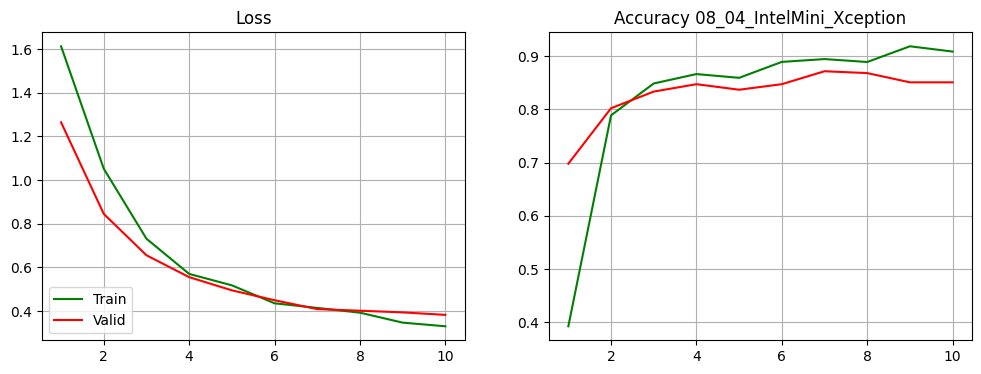

9/9 [==============================] - 182s 23s/step - loss: 0.3818 - accuracy: 0.8681
08_04_IntelMini_Mobilenet_224
Found 600 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Epoch 1/10
18/18 [==============================] - 15s 641ms/step - loss: 1.6269 - accuracy: 0.3398 - val_loss: 0.9748 - val_accuracy: 0.6562
Epoch 2/10
18/18 [==============================] - 10s 565ms/step - loss: 0.8914 - accuracy: 0.6796 - val_loss: 0.6236 - val_accuracy: 0.7674
Epoch 3/10
18/18 [==============================] - 9s 485ms/step - loss: 0.6210 - accuracy: 0.7905 - val_loss: 0.4763 - val_accuracy: 0.8229
Epoch 4/10
18/18 [==============================] - 10s 561ms/step - loss: 0.5107 - accuracy: 0.8310 - val_loss: 0.4372 - val_accuracy: 0.8646
Epoch 5/10
18/18 [==============================] - 10s 557ms/step - loss: 0.4567 - accuracy: 0.8468 - val_loss: 0.3796 - val_accuracy: 0.8681
Epoch 6/10
18/18 [============================

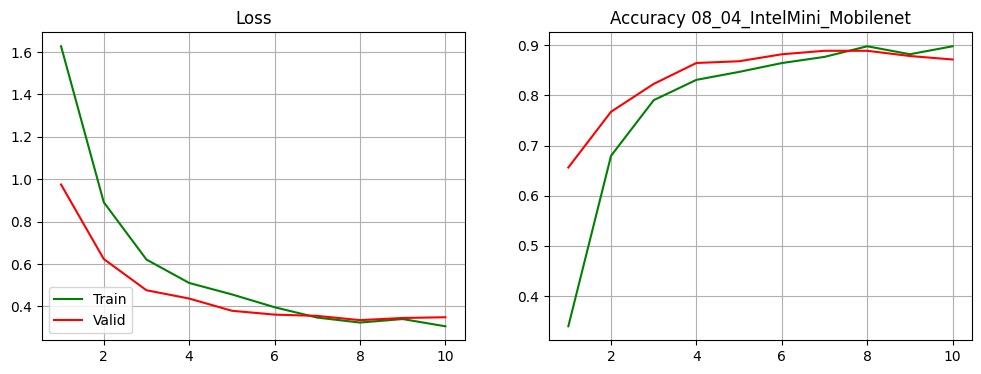

9/9 [==============================] - 1s 91ms/step - loss: 0.3526 - accuracy: 0.8542
08_04_IntelMini_DenseNet169_224
Found 600 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Epoch 1/10
18/18 [==============================] - 26s 788ms/step - loss: 1.7674 - accuracy: 0.3142 - val_loss: 1.2159 - val_accuracy: 0.5764
Epoch 2/10
18/18 [==============================] - 14s 807ms/step - loss: 1.1591 - accuracy: 0.5739 - val_loss: 0.7873 - val_accuracy: 0.7396
Epoch 3/10
18/18 [==============================] - 9s 520ms/step - loss: 0.7884 - accuracy: 0.7588 - val_loss: 0.5799 - val_accuracy: 0.8056
Epoch 4/10
18/18 [==============================] - 10s 565ms/step - loss: 0.6198 - accuracy: 0.8063 - val_loss: 0.4755 - val_accuracy: 0.8403
Epoch 5/10
18/18 [==============================] - 11s 602ms/step - loss: 0.5087 - accuracy: 0.8415 - val_loss: 0.4702 - val_accuracy: 0.8333
Epoch 6/10
18/18 [===========================

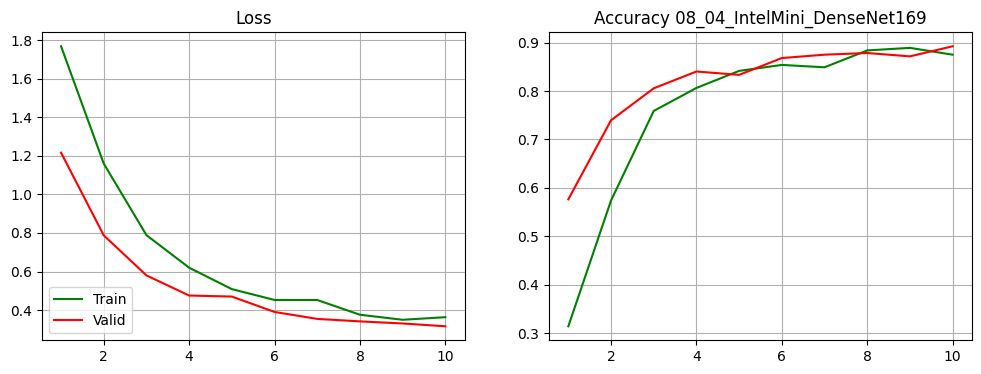

9/9 [==============================] - 1s 127ms/step - loss: 0.3272 - accuracy: 0.8750
08_04_IntelMini_EfficientNetV2B0_224
Found 600 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Epoch 1/10
18/18 [==============================] - 21s 660ms/step - loss: 1.5539 - accuracy: 0.3961 - val_loss: 1.1641 - val_accuracy: 0.6667
Epoch 2/10
18/18 [==============================] - 8s 463ms/step - loss: 0.9811 - accuracy: 0.7236 - val_loss: 0.7355 - val_accuracy: 0.8229
Epoch 3/10
18/18 [==============================] - 10s 561ms/step - loss: 0.6687 - accuracy: 0.8257 - val_loss: 0.5685 - val_accuracy: 0.8333
Epoch 4/10
18/18 [==============================] - 10s 592ms/step - loss: 0.5043 - accuracy: 0.8627 - val_loss: 0.4892 - val_accuracy: 0.8507
Epoch 5/10
18/18 [==============================] - 9s 482ms/step - loss: 0.4623 - accuracy: 0.8592 - val_loss: 0.4364 - val_accuracy: 0.8542
Epoch 6/10
18/18 [======================

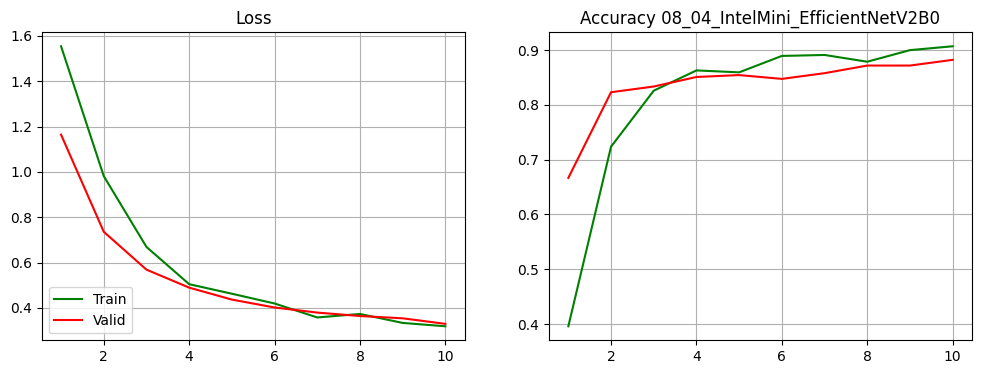

9/9 [==============================] - 1s 89ms/step - loss: 0.3181 - accuracy: 0.8924
#################################
Dataset Name - SportsMini
Dataset Path - /content/drive/MyDrive/Mgr/SportsMini/
Dataset contains 100 classes (['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'jud

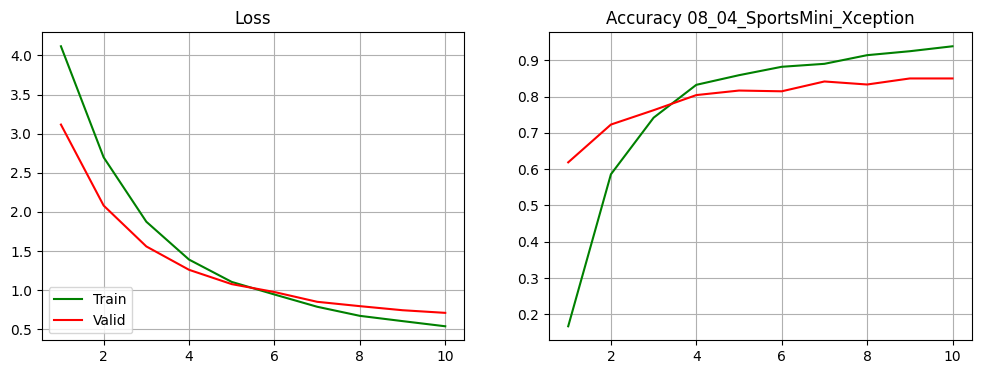

15/15 [==============================] - 341s 24s/step - loss: 0.6584 - accuracy: 0.8583
08_04_SportsMini_Mobilenet_224
Found 1500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Epoch 1/10
46/46 [==============================] - 27s 514ms/step - loss: 4.3783 - accuracy: 0.0783 - val_loss: 2.9337 - val_accuracy: 0.3542
Epoch 2/10
46/46 [==============================] - 23s 511ms/step - loss: 2.4660 - accuracy: 0.4264 - val_loss: 1.8935 - val_accuracy: 0.5896
Epoch 3/10
46/46 [==============================] - 22s 481ms/step - loss: 1.5463 - accuracy: 0.6458 - val_loss: 1.4081 - val_accuracy: 0.6812
Epoch 4/10
46/46 [==============================] - 24s 516ms/step - loss: 1.1437 - accuracy: 0.7575 - val_loss: 1.1304 - val_accuracy: 0.7542
Epoch 5/10
46/46 [==============================] - 23s 499ms/step - loss: 0.8740 - accuracy: 0.8283 - val_loss: 1.0100 - val_accuracy: 0.7583
Epoch 6/10
46/46 [=================

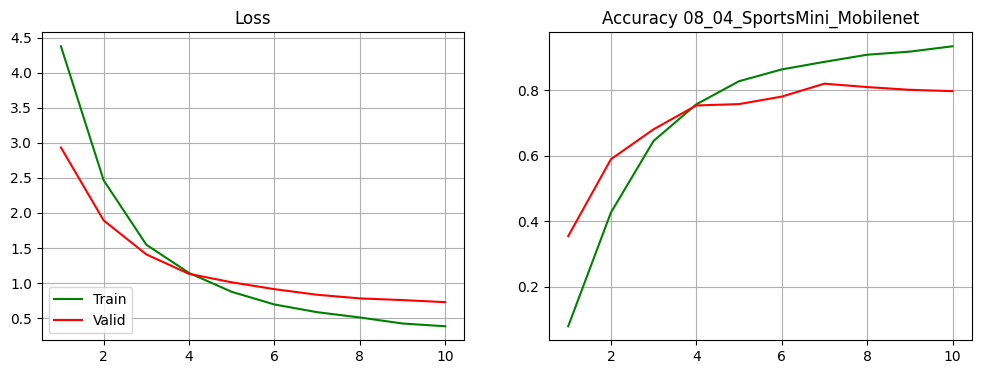

15/15 [==============================] - 2s 102ms/step - loss: 0.6808 - accuracy: 0.8167
08_04_SportsMini_DenseNet169_224
Found 1500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Epoch 1/10
46/46 [==============================] - 40s 644ms/step - loss: 4.6944 - accuracy: 0.0429 - val_loss: 3.4246 - val_accuracy: 0.2333
Epoch 2/10
46/46 [==============================] - 25s 541ms/step - loss: 3.0299 - accuracy: 0.3120 - val_loss: 2.2658 - val_accuracy: 0.5396
Epoch 3/10
46/46 [==============================] - 25s 536ms/step - loss: 2.0390 - accuracy: 0.5381 - val_loss: 1.6519 - val_accuracy: 0.6833
Epoch 4/10
46/46 [==============================] - 25s 550ms/step - loss: 1.4641 - accuracy: 0.7098 - val_loss: 1.2673 - val_accuracy: 0.7500
Epoch 5/10
46/46 [==============================] - 25s 546ms/step - loss: 1.1155 - accuracy: 0.7813 - val_loss: 1.0458 - val_accuracy: 0.7833
Epoch 6/10
46/46 [===============

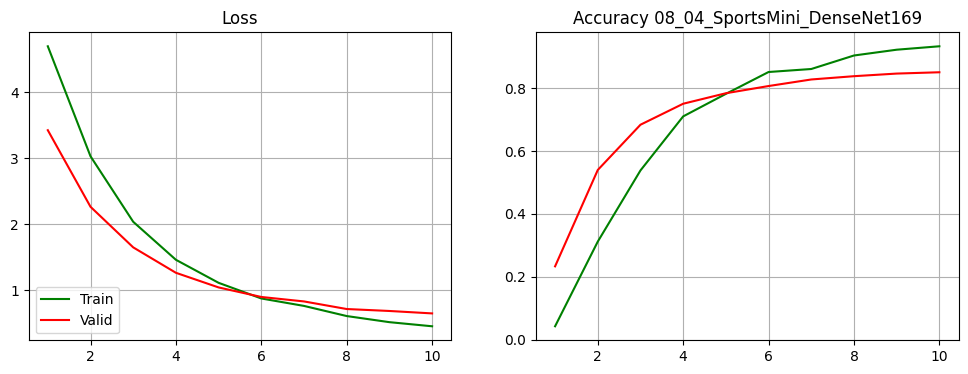

15/15 [==============================] - 2s 157ms/step - loss: 0.5825 - accuracy: 0.8604
08_04_SportsMini_EfficientNetV2B0_224
Found 1500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Epoch 1/10
46/46 [==============================] - 33s 551ms/step - loss: 4.0758 - accuracy: 0.1444 - val_loss: 3.0546 - val_accuracy: 0.5354
Epoch 2/10
46/46 [==============================] - 24s 526ms/step - loss: 2.5281 - accuracy: 0.5804 - val_loss: 1.9472 - val_accuracy: 0.7625
Epoch 3/10
46/46 [==============================] - 22s 470ms/step - loss: 1.6714 - accuracy: 0.7772 - val_loss: 1.3908 - val_accuracy: 0.7937
Epoch 4/10
46/46 [==============================] - 24s 520ms/step - loss: 1.1964 - accuracy: 0.8379 - val_loss: 1.0888 - val_accuracy: 0.8042
Epoch 5/10
46/46 [==============================] - 23s 497ms/step - loss: 0.9092 - accuracy: 0.8835 - val_loss: 0.9022 - val_accuracy: 0.8333
Epoch 6/10
46/46 [==========

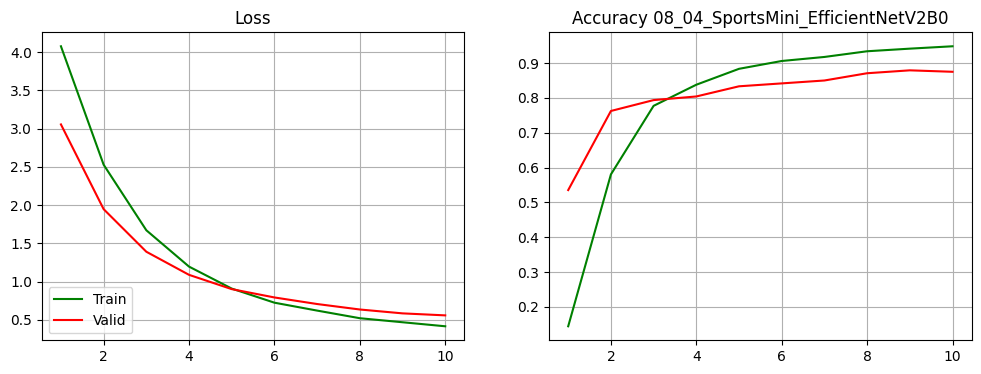

15/15 [==============================] - 1s 94ms/step - loss: 0.4987 - accuracy: 0.8958
#################################
Dataset Name - FlowersMini
Dataset Path - /content/drive/MyDrive/Mgr/FlowersMini/
Dataset contains 5 classes (['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']).
Train dataset contains 500 samples (15 steps / epoch)
Valid dataset contains 250 samples (7 steps / epoch)
08_04_FlowersMini_Xception_299
Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/10
15/15 [==============================] - 445s 30s/step - loss: 1.4396 - accuracy: 0.4423 - val_loss: 1.1950 - val_accuracy: 0.6562
Epoch 2/10
15/15 [==============================] - 16s 1s/step - loss: 1.0400 - accuracy: 0.7667 - val_loss: 0.8808 - val_accuracy: 0.8304
Epoch 3/10
15/15 [==============================] - 17s 1s/step - loss: 0.8055 - accuracy: 0.8034 - val_loss: 0.7113 - val_accuracy: 0.8482
Epoch 4/10
15/15 [============

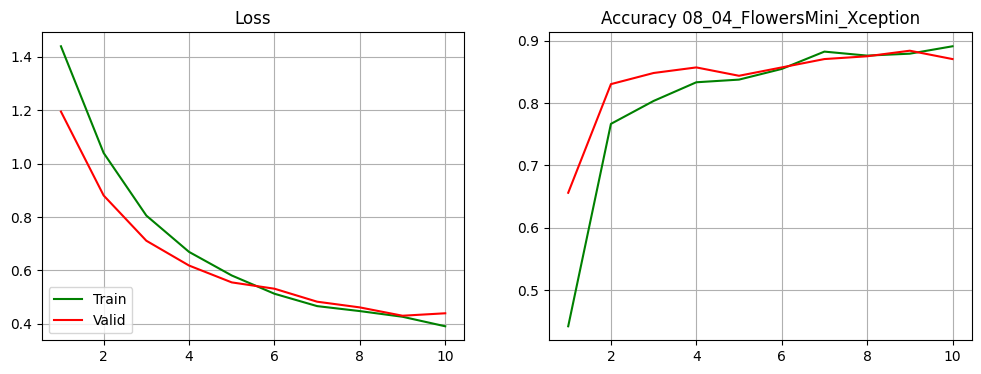

7/7 [==============================] - 137s 23s/step - loss: 0.5598 - accuracy: 0.7812
08_04_FlowersMini_Mobilenet_224
Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/10
15/15 [==============================] - 14s 708ms/step - loss: 1.6615 - accuracy: 0.3526 - val_loss: 1.1934 - val_accuracy: 0.5089
Epoch 2/10
15/15 [==============================] - 9s 617ms/step - loss: 1.0521 - accuracy: 0.5748 - val_loss: 0.8429 - val_accuracy: 0.6920
Epoch 3/10
15/15 [==============================] - 9s 626ms/step - loss: 0.7984 - accuracy: 0.7244 - val_loss: 0.6454 - val_accuracy: 0.8080
Epoch 4/10
15/15 [==============================] - 8s 533ms/step - loss: 0.6595 - accuracy: 0.7842 - val_loss: 0.5952 - val_accuracy: 0.8214
Epoch 5/10
15/15 [==============================] - 10s 685ms/step - loss: 0.5668 - accuracy: 0.8056 - val_loss: 0.5452 - val_accuracy: 0.8304
Epoch 6/10
15/15 [============================

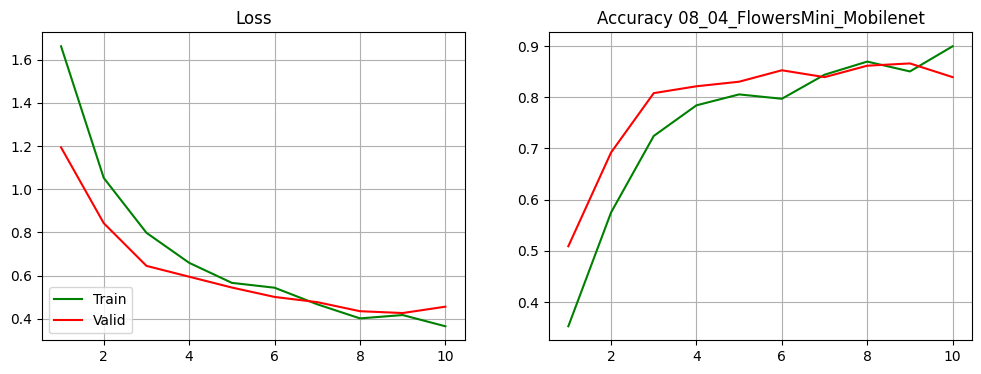

7/7 [==============================] - 1s 121ms/step - loss: 0.6300 - accuracy: 0.8036
08_04_FlowersMini_DenseNet169_224
Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/10
15/15 [==============================] - 24s 987ms/step - loss: 1.5070 - accuracy: 0.3739 - val_loss: 1.2271 - val_accuracy: 0.5893
Epoch 2/10
15/15 [==============================] - 9s 563ms/step - loss: 1.1096 - accuracy: 0.5897 - val_loss: 0.8969 - val_accuracy: 0.7009
Epoch 3/10
15/15 [==============================] - 9s 587ms/step - loss: 0.8180 - accuracy: 0.7372 - val_loss: 0.7037 - val_accuracy: 0.7991
Epoch 4/10
15/15 [==============================] - 11s 733ms/step - loss: 0.6920 - accuracy: 0.7821 - val_loss: 0.5776 - val_accuracy: 0.8438
Epoch 5/10
15/15 [==============================] - 10s 651ms/step - loss: 0.5434 - accuracy: 0.8313 - val_loss: 0.5593 - val_accuracy: 0.8393
Epoch 6/10
15/15 [=========================

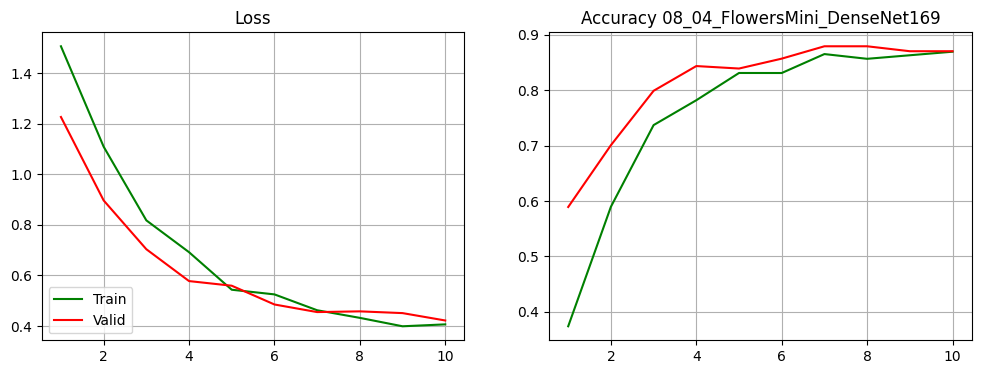

7/7 [==============================] - 1s 160ms/step - loss: 0.5034 - accuracy: 0.8482
08_04_FlowersMini_EfficientNetV2B0_224
Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/10
15/15 [==============================] - 18s 724ms/step - loss: 1.4652 - accuracy: 0.3889 - val_loss: 1.1302 - val_accuracy: 0.7054
Epoch 2/10
15/15 [==============================] - 9s 606ms/step - loss: 1.0337 - accuracy: 0.7073 - val_loss: 0.8362 - val_accuracy: 0.7991
Epoch 3/10
15/15 [==============================] - 8s 518ms/step - loss: 0.7818 - accuracy: 0.7863 - val_loss: 0.6766 - val_accuracy: 0.8259
Epoch 4/10
15/15 [==============================] - 9s 619ms/step - loss: 0.6332 - accuracy: 0.8376 - val_loss: 0.5754 - val_accuracy: 0.8527
Epoch 5/10
15/15 [==============================] - 9s 612ms/step - loss: 0.5734 - accuracy: 0.8355 - val_loss: 0.5362 - val_accuracy: 0.8527
Epoch 6/10
15/15 [======================

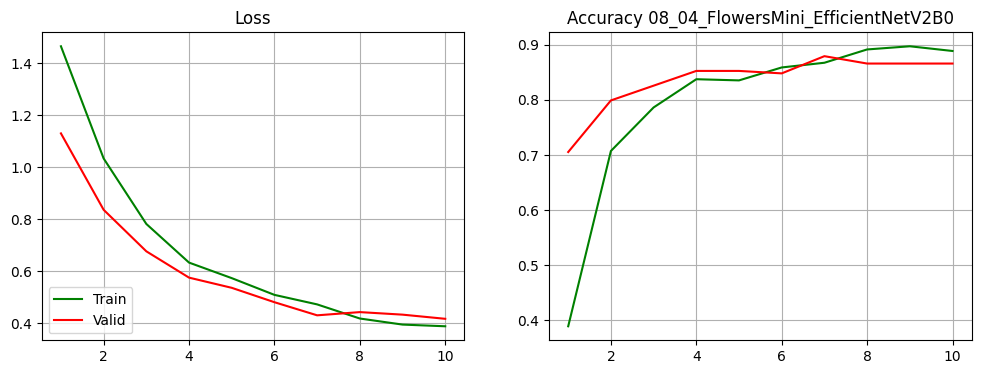

7/7 [==============================] - 1s 119ms/step - loss: 0.5412 - accuracy: 0.7812
#################################


In [ ]:
# comparision(DATASETS_INFO)